In [1]:
# Import libraries
import ast
import csv
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import pandas as pd
import glob, os
import re
import math
from tqdm import tqdm
from scipy.stats import stats
from scipy.stats import mannwhitneyu
import itertools
import seaborn as sns
import numpy.linalg as linalg

#tsne plot
from sklearn.manifold import TSNE

# To make the plot in the notebook and not in an extra window
%matplotlib notebook 

# Implement error messages (Default should be True)
error_on_missing_timestamps = False
error_on_time_light_mismatch = False
error_on_time_behavior_mismatch = False
error_on_missing_behaviors = False
error_on_invalid_behavior_range = False

In [2]:
#Open multiple .csv from single directory. Define existing behaviors. Define sample_ID and experiment_ID.
# Chris's FRAN is zero based!!, whereas old annotations are 1 based
#directory for behavior data

behavior_directories = [r'/Users/nadine/Documents/Zlatic_lab/close-loop/Notes/behavior_csv_cl_A4/'
                        #r'/Users/nadine/Documents/Zlatic_lab/close-loop/Notes/behavior_csv_cl_A9/',
                        #r'/Users/nadine/Documents/Zlatic_lab/close-loop/Notes/behavior_csv_ol/',
                        #r'/Users/nadine/Documents/Zlatic_lab/close-loop/Notes/behavior_csv_stim_artefact/'
                       ] 

behavior_files = []
for d in behavior_directories:
    behavior_files.extend(
        glob.glob(os.path.join(d, "*.csv"))) #join pathname with filename, 

# Behavior columns available in CSV files
available_behaviors = ('fw', 'bw', 'stim', 'hunch', 'turn', 'other', 'HP', 'left turn', 'right turn')

# Regular expression (define the expression filenames are searched for)
# '.' single character, matched everything, '*' 0>> occurences, '/' path delimiter, '\d' 0-9 digit,
# '+' 1>> occurences, 'L' here character from filename
# () outcome here: 2 groups, useful for extraction
# [] optional list, eg 1 --> 1
# ? character non or once 

# Behavior reg-ex (regular expression)
behavior_sample_re = re.compile('.*/(\d\d-\d\d-\d\dL\d+(-\d+)?)-behavior-(.+).csv')

# Function: readall_behavior iterates through all csv (sorted) 
# and appends the files into the list (ls) and returns dictionary
def readall_behavior(all_files, printit=False):
    data = {}
    for filename in sorted(all_files):
        # Find sample ID, file name pattern: YY-MM-DDLXDETAIL.csv,
        # exp_id = DETAIL: several measurements of same sample 
        # (cl (closeloop, RGECO/ Chronos), ol (openloop, RGECO/ Chronos), 
        # blocks (Raghav: GCaMP/Chrimson))
        # Larva ID: YY-MM-DDLX
        # Look for filename_components, which are true for pattern
        match = behavior_sample_re.match(filename)
        if not match:
            raise ValueError('Unexpected filename format: {}'.format(filename))
        filename_components = match.groups()
        #define filename_components sample_id (first group), and exp_id (sec group)
        part_sample_id, _, exp_id = filename_components         
        sample_id = "{}-{}".format(part_sample_id, exp_id)
        
        df = pd.read_csv(filename, index_col=None, header=0, delimiter = ';')
        df.fillna(0, inplace=True) #replace NaN with zero
        df['sample_id'] = sample_id  #add sample_id column
        df['exp_id'] = exp_id #add exp_id column
        data[sample_id] = df
        #Count 'True' for each column ('behavior') in each single behavior.csv)
        #print(filename, df[df == 1].count()) 
        #print(df)
    return data

behavior_data = readall_behavior(behavior_files)
#print(behavior_data['17-11-06L2-cl'])

In [3]:
# Frequency of each behavior in all imported behavior.csv by using the returned 'ls' from 
# the function readAll: concatenate the 'behavior_files' (global variable). 'True' for each 
# column ('behavior_type') in the concatenated file (df_behavior).
# Sorting has to be = False (warning message without 'sort')
df_behavior = pd.concat(behavior_data.values(), axis = 0, ignore_index = True, sort = False) #add sorting
print(df_behavior[df_behavior == 1].count()) 

START             8
END               0
fw             3479
bw              674
stim            201
hunch           301
turn           1416
other           134
HP              482
left turn       728
right turn      688
sample_id         0
exp_id            0
Unnamed: 11       0
dtype: int64


In [4]:
# Import and merge fluorescence data: Several LM files for the same sample_id exists, but differ in cell_id).
# List of LM data with two extra columns: sample_id and cell_id
# Open LM files from different directories
lightmicroscope_directories = [#r'/Users/nadine/Documents/Zlatic_lab/close-loop/Notes/Basin_traces/', 
                               #r'/Users/nadine/Documents/Zlatic_lab/close-loop/Notes/Handle-like_Traces',
                               #r'/Users/nadine/Documents/Zlatic_lab/close-loop/Notes/a00c_traces',
                               #r'/Users/nadine/Documents/Zlatic_lab/close-loop/Notes/candidate_neuron_traces',
                               r'/Users/nadine/Documents/Zlatic_lab/close-loop/Notes/All_ROI/26082017L6_allROIs_Claire/traces'
                              ] 

# Iterate through LM data and extend files in a list from within and between directory and 
# build a list of files from all directories
# (Note: append would 'extend' lists and not single files)
lightmicroscope_files = []
for d in lightmicroscope_directories:
    lightmicroscope_files.extend(
        glob.glob(os.path.join(d, "*.csv"))) #join pathname with filename

# Lightmicroscopic data reg-ex (regular expression)
lightmicroscope_sample_re = re.compile('.*/(\d\d-\d\d-\d\dL\d+(-\d+)?)-(.*)-(.*).csv')

# Function: readall_lm iterates through all LM_csv (sorted) 
# and returns a dictionary{key:value} 
# samples = {sample_id:cell-id}
def readall_lm(all_files):
    samples = {}
    for filename in sorted(all_files):
        # Find sample ID, file name pattern: YY-MM-DDLXDETAIL.csv,
        # Larva ID: YY-MM-DDLX, DETAIL = cell_id
        # Look for filename_components, which are true for pattern
        match = lightmicroscope_sample_re.match(filename)
        if not match:
            raise ValueError('Unexpected filename format: {}'.format(filename))
        filename_components = match.groups()
        part_sample_id, _, cell_id, exp_id = filename_components
        
        sample_id = "{}-{}".format(part_sample_id, exp_id)
        
        # Read LM.files 
        df = pd.read_csv(filename, index_col=None, header=0, delimiter = ',')
        # Replace NaN with zero
        df.fillna(0, inplace=True)
        
        # Add cellname to each column as prefix
        # lambda is a non defined function (longer version: def lambda(x):)
        # Rename of columns after the format cell_id, name) eg: Basin A9
        # inplace = True: column names are overwritten (if False: new dataframe)
        df.rename(lambda x: '{}_{}'.format(cell_id, x), axis = 'columns', inplace = True)
        # Get the sample_id (key) from the dictionary? to make a list [sample_cells] and 
        # if sample_id exists, append the list
        # if sample_id does not exists, start a new list
        # reminder: there can be several cell_id per sample_id
        sample_cells = samples.get(sample_id)
        if not sample_cells:
            samples[sample_id] = sample_cells = {
                'data': [],
                'exp_id': exp_id,
            }
        sample_cells['data'].append(df)
        
    return samples

lm_samples = readall_lm(lightmicroscope_files)

# New dictionary: lm_data{} to build a single dataframe with all cell_ids combined 
# for a single sample. Iterate over dict from same sample in one dataframe. 
# df.items iterate over pairs and build a list

lm_data = {}

# Iterate over all light samples and merge all found files
# for each sample into a single data frame (per sample)
for sample_id, sample_info in lm_samples.items():
    cells_dataframes = sample_info['data']
    #check if number of cells >= 1
    if not cells_dataframes:
        raise ValueError('No cells found for sample {}'.format(sample_id))
    #first element in the list
    lm_df = None

    #iteration through other df
    for cdf in cells_dataframes:
        if lm_df is None:
            lm_df = cdf
        else:
            if len(lm_df.index) != len(cdf.index):
                raise ValueError('Data frame frame to merge has not same row count as target', sample_id)
            lm_df = pd.merge(lm_df, cdf, left_index = True, right_index = True)
            
    lm_df['sample_id'] = sample_id  #add sample_id column
    lm_df['exp_id'] = sample_info['exp_id']
    lm_data[sample_id] = lm_df
#print(list(lm_data.keys()))
#print(lm_samples)

In [5]:
# Import txt-files from of the absolute time/frame from the Ca-imaging (lm-data). 
# All txt-files have to be transposed, which is a memory intensive step. After the 
# data are complete, the transposed files should be exported (ToDo). Time-data are 
# combined with sample-ID and experiment-ID.

timelapse_directory =(r'/Users/nadine/Documents/Zlatic_lab/close-loop/Notes/timelapse/') 
timelapse_files = glob.glob(os.path.join(timelapse_directory, "*.txt")) #join pathname with filename

# Behavior reg-ex (regular expression)
time_sample_re = re.compile('.*/(\d\d-\d\d-\d\dL\d+(-\d+)?)-time-(.+).txt')

# Function: readall_timelapse iterates through all txt (sorted) and appends the 
# files into the dict (data) and returns ls
def readall_time(all_files, printit=False):
    data = {}
    for filename in sorted(all_files):
        # Find sample ID, file name pattern: YY-MM-DDLXDETAIL.csv,
        # exp_id = DETAIL: several measurements of same sample (cl (closeloop), ol (openloop), blocks (Raghav))
        # Larva ID: YY-MM-DDLX
        #look for filename_components, which are true for pattern
        match = time_sample_re.match(filename)
        if not match:
            raise ValueError('Unexpected filename format: {}'.format(filename))
        filename_components = match.groups()
        part_sample_id, _, exp_id = filename_components #define filename_components sample_id (first group), and exp_id (sec group)  
        sample_id = "{}-{}".format(part_sample_id, exp_id)
        
        df = pd.read_csv(filename, header=1, index_col=None, delim_whitespace = True)
        df = df.T #transposing because read_csv imports as row
        df = df.reset_index() #transpose function sets data as index
        df.rename(columns={'index':'time'}, inplace=True) #rename reset index column to time
        df['time'] = df.time.astype(float)
        data[sample_id] = df
        
    return data

In [6]:
# Keep in mind that some of the files has to be changed because of the discrepancy in timestamps
#Will fixed this in vsc
timelapse_cache = 'timelapse.cache'

try:
    with open(timelapse_cache, 'r') as timelapse_cache_file:
        # TODO
        cache_data = timelapse_cache_file.read()
        time_data = ast.literal_eval(cache_data)
except FileNotFoundError as e:
    print('No cache file found, recomputing')
    # No cache file found, recompute
    time_data = readall_time(timelapse_files)
    # Write cache
    

No cache file found, recomputing


In [7]:
sample_data = {}

# Time data are merged into light data and checked if number length of lm = timestamp.  
# Due to technical conditions, some time.txt-file have too many or not enough time data compared
# to the corresponding LM data. The discrepancy is fixed by either dropping the extra timepoints or 
# by taking the average of the difference between each timepoint and extend the dataframe. 
# The first 10 timepoints are not included to account for instability of the microscope in 
# the beginning due to the moving parts. 
# Maximal difference between timepoints fyi.

for sample_id, sample_df in lm_data.items():
    # Add time stamps to data frame of current sample by merging
    # The time data frame for the current sample, which is expected
    # to match the light data (based on index).
    timestamp_df = time_data.get(sample_id)
    if timestamp_df is None:
        msg = '{}: could not find timestamp data for sample'.format(sample_id)
        if error_on_missing_timestamps:
            raise ValueError(msg)
        # Ignore, if missing data shouldn't cancel the whole process.
        print(msg)
        continue
        
    n_timestamps = len(timestamp_df)
    n_lightdata = len(sample_df)
    
    # The timestamp and light recordings are done by different systems.
    # This can cause the existence of additional time points/ or missing time points in a
    # dataset, which will be filtered out in the merge operation below.
    if n_lightdata != n_timestamps:
        msg = '{}: time data ({} entries) doesn\'t match light data ({} entries)'.format(
                sample_id, n_timestamps, n_lightdata)
        if error_on_time_light_mismatch:
            raise ValueError(msg)
        print(msg)
        diffs = np.diff(timestamp_df['time'])[10:] #from 10th row onwards
        diffs_avg = diffs.mean(axis=0)
        #diff between timedata and lightdata
        missing_data = len(sample_df) - len(timestamp_df)
        
        #add 'diffs_avg' to fill in missing_timedata
        if missing_data > 0:
            last_valid_index = len(timestamp_df) - 1
            last_timestamp = timestamp_df.iloc[last_valid_index]['time']
            if pd.isna(last_timestamp):
                raise ValueError('Unexpected last valid timestamp for sample {} at index {}'.format(
                        sample_id, last_valid_index))
            for i in range(0, missing_data):
                last_valid_index += 1
                timestamp_df.loc[last_valid_index] = timestamp_df.iloc[last_valid_index - 1]['time'] + diffs_avg
        elif missing_data < 0:
            drop_start = len(timestamp_df) + missing_data
            drop_end = len(timestamp_df)
            timestamp_df.drop(list(range(drop_start, drop_end)))

    # Merge timedata into light data
    # Use an 'inner' join/merge to exclude time points that don't have matching light data.
    new_sample_df = pd.merge(sample_df, timestamp_df, left_index = True, right_index = True, how='inner')
    
    # Store newly created data frame for sample (dictionary)
    sample_data[sample_id] = new_sample_df
    
print('Matched {} light data sets with their respective time points'.format(len(sample_data)))

# Max.diffs for timestamps
# diffs defined earlier
#mx = diffs.max()
#print('max-diff', mx)

#plt.hist(diffs, bins=10, alpha=0.5)
#plt.show() 

Matched 1 light data sets with their respective time points


In [8]:
# Combine behavior data with light data into a single data frame
# per sample ID. To do so, add behavior data to light data frames,
# because the light data is already organizes by frame. To accomodate
# frame ranges without an behavior data, a column named "quiet" is
# added which is True in these cases and False otherwise. Additionally,
# for each behavior column, a behavior start and end column as well as
# an overlap column is added so that parallel and successive behaviors
# of the same type can be differentiated.

for sample_id, sample_df in sample_data.items():
    sample_behavior = behavior_data.get(sample_id)
    if sample_behavior is None:
        msg = 'Could not find behavior data for sample "{}"'.format(sample_id)
        if error_on_missing_behaviors:
            raise ValueError(msg)
        print(msg)
        continue

    # Add extra columns for behavior
    for behavior in available_behaviors:
        sample_df[behavior] = False
        sample_df['{}_start'.format(behavior)] = False
        sample_df['{}_end'.format(behavior)] = False
        sample_df['{}_overlap'.format(behavior)] = False
    
    # Add 'quiet' column. Set it initially to True and mark frames
    # with actual behavior as quiet = False.
    sample_df['quiet'] = True
    
    n_light_entries = len(sample_df)

    # Iterate over behavior data and add data to target data frame
    for i, row in sample_behavior.iterrows():
        # Start and end are 1-based, make them 0-based
        start = int(row['START'])
        end = int(row['END'])
        
        if type(row['START']) == str:
            print(sample_id)
            print(start, end)
        
        if start >= end:
            msg = "{}: start ({}) needs to be strictly smaller than end ({})".format(sample_id, start, end)
            if error_on_invalid_behavior_range:
                raise ValueError(msg)
            print(msg)
            continue
        
        # Make sure we capture start/end times that are a fractional number.
        if row['START'] - start > 0 or row['END'] - end > 0:
            raise ValueError('{}: start and end frame number can\'t contain fractions'.format(sample_id))
            
        # Ignore behavior entries with an end frame higher than available light data.
        # The behavior data is one-based, which is why a strict larger than test should
        # be correct.
        if end > n_light_entries:
            msg = 'Sample: {} - Behavior row with range {}-{} exceeds light time points ({}): {}'.format(
                sample_id, start, end, n_light_entries, row)
            if error_on_time_behavior_mismatch:
                raise ValueError(msg)
            print(msg)
            continue
            
        # Find behavior observed in row
        observed_behaviors = []
        for behavior in available_behaviors:
            if row[behavior]:
                observed_behaviors.append(behavior)
        
        # We assume that not more than two behaviors are observed at the same time
        if len(observed_behaviors) > 2:
            raise ValueError('Found multiple behaviors in row {} of sample {}'.format(i, sample_id))
        
        # Add observed behavior information to target data frames in all
        # rows in behavior range.
        for b in observed_behaviors:
            # Iterate over frames valid for current behavior. Every valid
            # frame is mapped into the canonical (light/cell) data frame,
            # which is 0-indexed.
            for j in range(start, end + 1):
                # Behavior ranges are 1-indexed
                current_frame = j - 1
                # If the current behavior has already been observed at this frame,
                # set overlap to True, because we are about to mark this behavior
                # again as observed for this frame.
                if sample_df.at[current_frame, b]:
                    sample_df.at[current_frame, '{}_overlap'.format(b)] = True
                else:
                    sample_df.at[current_frame, b] = True
                
                # Mark this row as not quiet, because we observed
                # a behavior in the current frame.
                sample_df.at[current_frame, 'quiet'] = False

            sample_df.at[start - 1, '{}_start'.format(b)] = True
            sample_df.at[end - 1, '{}_end'.format(b)] = True
            
    # Mark quiet ranges with _start, _end and _overlap. By definion,
    # quiet_overlap is always False.
    sample_df['quiet_start'] = False
    sample_df['quiet_end'] = False
    sample_df['quiet_overlap'] = False
    last_sample_idx = n_light_entries - 1
    for i, row in sample_df.iterrows():
        sample_df.at[i, 'quiet_start'] = row['quiet'] and (i == 0 or not sample_df.at[i - 1, 'quiet'])
        sample_df.at[i, 'quiet_end'] = row['quiet'] and (i == last_sample_idx or not sample_df.at[i + 1, 'quiet'])


In [9]:
# Define a class with sample_id, cell_type, event_name and filter_pattern

class CellTraceConfig:
    
    def __init__(self, sample_id, cell_type, event_name, filter_pattern=None):
        self.sample_id = sample_id
        self.cell_type = cell_type
        self.event_name = event_name
        self.filter_pattern = filter_pattern
        
    def get_filter_regex(self):
        filter_regex = '^{}_'.format(self.cell_type)
        if self.filter_pattern:
            filter_regex += '.*{}.*'.format(self.filter_pattern)
        return filter_regex
    
    def get_event_start_col(self):
        return '{}_start'.format(self.event_name)

    def add_event_time_points_to_plot(self, source_df, plot):
        for idx, row in source_df.iterrows():
            plot.annotate(self.event_name, xy=(row['time'], 1))
            plt.axvline(row['time'], color='k', linestyle='-')  
            
# Define a class with sample_id, cell_type, event_time and filter_pattern (for behavioral_transitions)
# Put '' [empty string] if you dont want any cell type

class CellTransConfig:
    
    def __init__(self, sample_id, cell_type, event_time, filter_pattern=None, first_event=None, second_event=None):
        self.sample_id = sample_id
        self.cell_type = cell_type
        self.event_time = event_time
        self.filter_pattern = filter_pattern
        self.first_event = first_event
        self.second_event = second_event
        
    def get_filter_regex(self):
        if self.cell_type is None:
            cell_str = r"[a-zA-Z0-9]+"
        else:
            cell_str = self.cell_type
            
        filter_regex = '^{}_'.format(cell_str)
        if self.filter_pattern:
            filter_regex += '.*{}.*'.format(self.filter_pattern)
        return filter_regex
    
    
    
# Define a class for filtering after behavioral_transitions for either only cell_type or filter_pattern or both.
# For example to average not only over all A00cs but all A00c_midL.

class DataFilter():
    def __init__(self, cell=None, pattern=None):
        self.cell = cell if cell is not None else '.*' # Makes argument optional
        self.pattern = pattern if pattern is not None else '.*' # Makes argument optional
        
    def get_cell_filter_regex(self):
        filter_regex = '.*_{}_.*_.*'.format(self.cell)
        return filter_regex
    
    def get_pattern_filter_regex(self):
        filter_regex = '.*_.*_{}_.*'.format(self.pattern)
        return filter_regex
    
    def get_cellpattern_filter_regex(self):
        filter_regex = '.*_{}_{}_.*'.format(self.cell, self.pattern)
        return filter_regex
        
    def __str__(self):
        return "{}_{}".format(self.cell, self.pattern)   
    
    
# Define class to group the columns after cell_type/ pattern or both using the class Datafilter

class TransitionGrouper:
    def __init__(self, transitions_df):
        self.transitions_df = transitions_df
        
        sample_ids, cells, patterns, *_ = zip(*[column.split("_") for column in self.transitions_df.columns])
        
        self.sample_ids = sorted(set(sample_ids))
        self.cells = sorted(set(cells))
        self.patterns = sorted(set(patterns))
        
    def get_regex(self, cell_name=None, pattern=None):
        data_filter = DataFilter(cell=cell_name, pattern=pattern)
        if cell_name is not None and pattern is None:
            return data_filter, data_filter.get_cell_filter_regex()
        if cell_name is not None and pattern is not None:
            return data_filter, data_filter.get_cellpattern_filter_regex()
        if cell_name is None and pattern is not None:
            return data_filter, data_filter.get_pattern_filter_regex()
        raise ValueError("Both cell_name and pattern are None! :(")
    
    def group_cells(self):
        output = dict()
        for cell_name in self.cells:
            data_filter, regex = self.get_regex(cell_name)
            cell_df = self.transitions_df.filter(regex=regex)
            output[cell_name] = (str(data_filter), cell_df)
        return output
    
    def group_patterns(self):
        output = dict()
        for pattern in self.patterns:
            data_filter, regex = self.get_regex(pattern=pattern)
            pattern_df = self.transitions_df.filter(regex=regex)
            output[pattern] = (str(data_filter), pattern_df)
        return output
    
    def group_cellpattern(self):
        output = dict()
        for cell_name, pattern in itertools.product(self.cells, self.patterns):
            data_filter, regex = self.get_regex(cell_name, pattern)
            cellpattern_df = self.transitions_df.filter(regex=regex)
            output[(cell_name, pattern)] = (str(data_filter), cellpattern_df)
        return output

# Specific after Post-transitions for multiple transition kinds, used for plotting. For multiple transition 
# events, group after transition (first, or second event) <most useful> with option to group
# after celltype, filterpattern, sample_id, observations.
class TransitionType:
    def __init__(self, sample_id=".*", cell=".*", filter_pattern=".*", n_obs=".*", first_event=".*", second_event=".*"):
        self.sample_id = sample_id
        self.cell = cell
        self.filter_pattern = filter_pattern
        self.n_obs = n_obs
        self.first_event = first_event
        self.second_event = second_event
        
        self.pattern = "{}_{}_{}_{}_{}_{}"
        
    def get_filter_regex(self, use_all=False, use_cell=False, use_sample=False, use_filter_pattern=False, use_n_obs=False, use_first_event=False, use_second_event=False):
        filter_regex = self.pattern.format(self.sample_id if use_sample or use_all else ".*",
                                          self.cell if use_cell or use_all else ".*",
                                          self.filter_pattern if use_filter_pattern or use_all else ".*",
                                          self.n_obs if use_n_obs or use_all else ".*",
                                          self.first_event if use_first_event or use_all else ".*",
                                          self.second_event if use_second_event or use_all else ".*")
        return filter_regex    
    
    


In [10]:
#########################################

In [11]:
#for specific behavior

In [12]:
#Generate cell_df with time as index
timestamp = sample_df['time']
temp = pd.DataFrame(timestamp) 

lm_df_cell = lm_df.drop(columns=['sample_id', 'exp_id'], axis = 1)

cell_df = pd.merge(temp, lm_df_cell, left_index=True, right_index=True)
# Rename time collum to time
cell_df.rename(columns={ cell_df.columns[0]: 'time' }, inplace = True) 
print(cell_df)



          time     C_C_1    C_C_10   C_C_100  C_C_1000   C_C_101   C_C_102  \
0        0.000 -0.157430  0.025641 -0.011470  0.008992  0.007389  0.126880   
1        0.323 -0.034511 -0.025253 -0.028921  0.029346  0.010663  0.030612   
2        0.644  0.009812  0.068506  0.033878  0.020100  0.072942  0.122080   
3        0.964  0.104270  0.119380  0.001901  0.017084  0.008807  0.110330   
4        1.285  0.148640  0.098164  0.024713  0.000000  0.000000  0.159920   
5        1.605  0.230170  0.144860  0.041979  0.039223  0.069483  0.089582   
6        1.926  0.225330  0.181910  0.034285 -0.003869  0.029844 -0.010130   
7        2.246  0.240240  0.075662  0.078236  0.019191  0.023135  0.114330   
8        2.567  0.275180  0.068987  0.031378  0.005577 -0.003713  0.065943   
9        2.887  0.278040  0.086145  0.000998  0.001487  0.008318  0.183350   
10       3.208  0.254090  0.103270  0.078338  0.002081  0.059221  0.099059   
11       3.528  0.238980 -0.007210  0.034251  0.022363  0.083329

In [22]:
# Neuronal activity of a certain behavior (all behavior from the same type, independent on pre- and post-event)
# For all behavior events (same type) get event_time 
#ToDo
# implement n-behavior
# how to deal with different duration of behavior?

cell = "C_C" 
#pattern = 'mid'
desired_behavior = "turn"
align_to_start = True

sample_ids = []
start_times = []
end_times = []
desired_traces = []

# Checkpoint if not all behavior data are used for analysis, but dff and timestamps are available
for sample_id, sample_df in tqdm(sample_data.items()):
    if any(["bw" in column for column in sample_df.columns]):
        for i, row in sample_df.iterrows():
            if row["{}_start".format(desired_behavior)]:  
                start_times.append(row["time"])
                sample_ids.append(sample_id)
            if row["{}_end".format(desired_behavior)]: 
                end_time = row["time"]
                end_times.append(row["time"])
        assert len(end_times) == len(start_times), "{} start times vs {} end times on sample {}".format(len(start_times), len(end_times), sample_id)

for sample_id, start_time, end_time in zip(sample_ids, start_times, end_times):
    print(sample_id, start_time, end_time) #ok
    if align_to_start:
        desired_traces.append(CellTransConfig(sample_id, cell,
                                              start_time))
    else:
        desired_traces.append(CellTransConfig(sample_id, cell, 
                                              end_time))

print(len(desired_traces))
#print(type(desired_traces))
#print(desired_traces) #no


100%|██████████| 1/1 [00:05<00:00,  5.08s/it]

17-08-26L6-cl 60.895 63.459
17-08-26L6-cl 66.024 68.907
17-08-26L6-cl 69.229 71.471
17-08-26L6-cl 75.958 77.561
17-08-26L6-cl 81.407 84.611
17-08-26L6-cl 93.585 97.431
17-08-26L6-cl 100.636 103.199
17-08-26L6-cl 110.571 112.494
17-08-26L6-cl 115.378 119.865
17-08-26L6-cl 217.935 218.576
17-08-26L6-cl 303.505 306.069
17-08-26L6-cl 309.274 311.838
17-08-26L6-cl 313.44 315.363
17-08-26L6-cl 318.247 320.17
17-08-26L6-cl 323.054 325.939
17-08-26L6-cl 328.183 331.387
17-08-26L6-cl 336.195 339.078
17-08-26L6-cl 344.206 345.488
17-08-26L6-cl 350.296 353.821
17-08-26L6-cl 751.547 753.47
17-08-26L6-cl 755.072 756.675
17-08-26L6-cl 760.841 763.085
17-08-26L6-cl 764.367 765.649
17-08-26L6-cl 769.174 770.135
17-08-26L6-cl 773.34 775.904
17-08-26L6-cl 776.865 779.108
17-08-26L6-cl 780.07 783.275
17-08-26L6-cl 792.249 794.172
17-08-26L6-cl 849.616 850.898
17-08-26L6-cl 1015.309 1016.911
17-08-26L6-cl 1018.834 1021.398
17-08-26L6-cl 1027.808 1030.051
17-08-26L6-cl 1031.974 1034.859
17-08-26L6-cl 1045.

In [23]:
behavior = []

for start_time, end_time in zip(start_times, end_times):
    beh = cell_df[(cell_df.time >= start_time) & (cell_df.time <= end_time)]
    behavior.append(beh)
print(behavior)    
    
    
    

[       time     C_C_1    C_C_10   C_C_100  C_C_1000   C_C_101   C_C_102  \
190  60.895  0.180960  0.052968  0.050682  0.006264  0.035133  0.054125   
191  61.216  0.141630  0.029239 -0.000127  0.004691  0.024154  0.051679   
192  61.536  0.101210  0.139130  0.032052  0.004478 -0.012880  0.021826   
193  61.856  0.126080  0.193270  0.007607  0.014241  0.035133  0.165210   
194  62.177  0.082604  0.114940  0.041123  0.034841  0.031051  0.192080   
195  62.498  0.081933  0.133170  0.059932  0.005302  0.015476  0.056020   
196  62.818  0.074986  0.048757  0.000513  0.019127 -0.017804  0.068342   
197  63.139  0.058423  0.179120 -0.006483  0.044277  0.021378  0.069324   
198  63.459  0.074092  0.192100  0.061784  0.047555  0.001907  0.131200   

      C_C_103   C_C_104   C_C_105  ...  C_C_4381  C_C_4382  C_C_4383  \
190  0.090917  0.060176  0.131100  ...  0.016384  0.029555  0.029980   
191  0.101690  0.044886  0.056443  ...  0.008772 -0.000487  0.004145   
192  0.125920  0.005980  0.19606

In [ ]:
# ToDo drop time

<IPython.core.display.Javascript object>


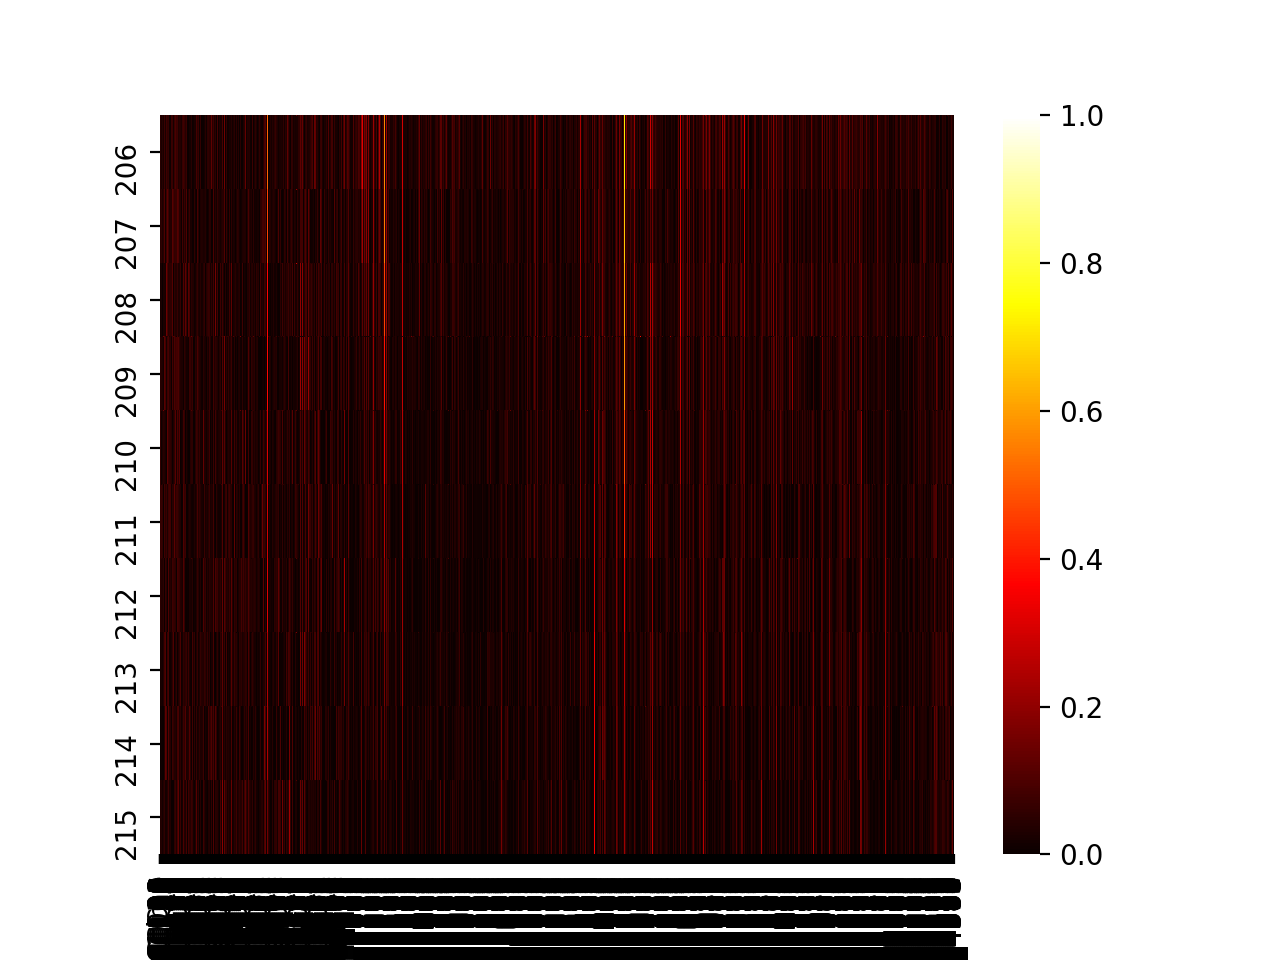

In [27]:

%matplotlib notebook 

ax = sns.heatmap(behavior[1], vmin=0, vmax=1, cmap = 'hot', xticklabels=1, yticklabels=1)
plt.show()